# GAN for MNIST
Recently I read about GANs and I was blown away by the iheir capabilities. The idea of GAN is simple and beautiful. I am following this [tutorial](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html). Lets learn more about them!!!

### Importing modules 
Importing the important modules we need. 

In [31]:
from __future__ import print_function
import argparse 
import os
import random
import torch 
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
%matplotlib inline

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


### Defining the Inputs to the network 

In [84]:
dataroot = './data/celeba'  #Root Directory for the dataset 
workers = 2  #Number of threads for loading data with DataLoader 
batch_size = 128  #batch size during training 
image_size = 28  #The image is 64x64
nc = 1 #Number of Channels. 

nz = 100 #Size of latent vector imput to the generator. 
ngf = 64 #Relates to the depth of feature maps carried thorugh generator. 
ndf = 64 #Sets the depth of feature maps propagated through the discriminator. 

num_epochs = 300
lr = 0.0002
beta1 = 0.5 #For adam optimizers
ngpu = 1 #num of gpus used 

### Loading the Data
torch.utils.data.DataLoader gives us a python iterable for the dataset. 
Also checkout how we loaded the data in the DCGAN tutorials from a folder. 

In [33]:
def mnist_data():
    compose = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize([0.5], [0.5])
        ])
    out_dir = './data'
    return dset.MNIST(root=out_dir, train=True, transform=compose, download=True)# Load data
dataset = mnist_data()

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)


device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

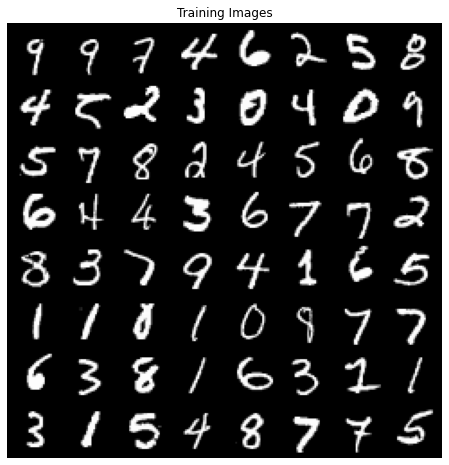

In [34]:

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

### Weight Initialisation
The authors of DCGAN have specified to initialize all the model weights using a normal distribution with mean = 0, standard_deviation = 0.02

Look how beautifully the tutorial has implemented this. These are the small things in pytorch that we can learn. 

In [35]:
def weights_init(m):
    classname = m.__class__.__name__  # We get the name of the class from the object!
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

### Generator 
So our generator generates the fake samples from a [latent space](https://towardsdatascience.com/understanding-latent-space-in-machine-learning-de5a7c687d8d) vector. Basically the latent space is a compressed encoding of complex information. Using this information we want to get actual data. Generator helps us in doing that. 

The input tensor to the generator is of shape (num_tensors, tensor_shape, 1, 1). 
We project our tensor as having nz channels with 1x1 pixels in each channel. 

nn.ReLU(inplace = True) this means perform x = nn.ReLU(x) 

In [40]:
class Generator(nn.Module) :
    def __init__(self, ngpu) :
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.Linear(nz, 128), 
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 256),
            nn.LeakyReLU(0.2, True), 
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, True),
            nn.Linear(512, image_size*image_size)
        )
    def forward(self, input):
        input = input.view(input.size(0), nz)
        return self.main(input)

netG = Generator(ngpu).to(device)
netG(torch.zeros(2, nz, 1, 1).to(device)).shape  # Sample Back Propagation 

# netG.apply(weights_init)


torch.Size([2, 784])

### Discriminator 
The discriminator is a binary classification network whose job is to distinguish between real samples and the fake samples( generated by generator). 

In [41]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
                    nn.Linear(image_size*image_size, 512), 
                    nn.LeakyReLU(0.2, True), 
                    nn.Linear(512, 256),
                    nn.LeakyReLU(0.2, True),
                    nn.Linear(256, 128), 
                    nn.LeakyReLU(0.2, True), 
                    nn.Linear(128, 1), 
                    nn.Sigmoid()
        )
    
    def forward(self, input):
        input = input.view(input.size(0), image_size*image_size*nc)
        return self.main(input)

netD = Discriminator(ngpu).to(device)
netD.apply(weights_init)
netD(x).shape


torch.Size([2, 1])

### Loss Functions and Optimisers
We use the binary cross entropy loss here. The optimizer used is adam. 

In [42]:
criterion = nn.BCELoss()

fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Convention for real and fake labels. 
real_label = 1
fake_label = 0

optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

### Training the GAN
Seems like you have to be very careful while training a GAN. [Here](https://github.com/soumith/ganhacks) is a very popular resource. 

Starting the training loop!!
[0/300][0/469]	Loss_D: 0.3215	Loss_G: 2.9297	D(x): 0.8740	D(G(z)): 0.0725 / 0.1232
[0/300][50/469]	Loss_D: 0.2759	Loss_G: 3.9950	D(x): 0.9278	D(G(z)): 0.1011 / 0.0389
[0/300][100/469]	Loss_D: 0.2386	Loss_G: 4.4186	D(x): 0.9365	D(G(z)): 0.1066 / 0.0266
[0/300][150/469]	Loss_D: 0.2549	Loss_G: 4.2763	D(x): 0.9138	D(G(z)): 0.0682 / 0.0321
[0/300][200/469]	Loss_D: 0.3143	Loss_G: 5.1209	D(x): 0.9488	D(G(z)): 0.1414 / 0.0156
[0/300][250/469]	Loss_D: 0.4011	Loss_G: 3.6769	D(x): 0.8316	D(G(z)): 0.0324 / 0.0745
[0/300][300/469]	Loss_D: 0.3622	Loss_G: 4.2313	D(x): 0.9267	D(G(z)): 0.1299 / 0.0353
[0/300][350/469]	Loss_D: 0.3520	Loss_G: 2.9494	D(x): 0.8683	D(G(z)): 0.0522 / 0.1068
[0/300][400/469]	Loss_D: 0.2504	Loss_G: 4.9091	D(x): 0.9376	D(G(z)): 0.1032 / 0.0192
[0/300][450/469]	Loss_D: 0.3370	Loss_G: 3.5960	D(x): 0.8786	D(G(z)): 0.0472 / 0.0740
[1/300][0/469]	Loss_D: 0.2896	Loss_G: 4.2171	D(x): 0.9299	D(G(z)): 0.1368 / 0.0329
[1/300][50/469]	Loss_D: 0.2642	Loss_G: 4.

[9/300][350/469]	Loss_D: 0.2756	Loss_G: 4.2212	D(x): 0.9194	D(G(z)): 0.0933 / 0.0367
[9/300][400/469]	Loss_D: 0.2865	Loss_G: 5.3383	D(x): 0.9490	D(G(z)): 0.1532 / 0.0105
[9/300][450/469]	Loss_D: 0.4163	Loss_G: 5.3594	D(x): 0.9524	D(G(z)): 0.1750 / 0.0159
[10/300][0/469]	Loss_D: 0.2310	Loss_G: 4.6862	D(x): 0.9411	D(G(z)): 0.0989 / 0.0189
[10/300][50/469]	Loss_D: 0.3230	Loss_G: 3.6847	D(x): 0.8906	D(G(z)): 0.0802 / 0.0579
[10/300][100/469]	Loss_D: 0.1952	Loss_G: 4.8681	D(x): 0.9352	D(G(z)): 0.0722 / 0.0299
[10/300][150/469]	Loss_D: 0.3018	Loss_G: 4.6682	D(x): 0.9440	D(G(z)): 0.1463 / 0.0286
[10/300][200/469]	Loss_D: 0.2864	Loss_G: 3.9414	D(x): 0.9007	D(G(z)): 0.0827 / 0.0427
[10/300][250/469]	Loss_D: 0.2907	Loss_G: 5.4082	D(x): 0.9455	D(G(z)): 0.1513 / 0.0094
[10/300][300/469]	Loss_D: 0.3212	Loss_G: 4.5901	D(x): 0.9222	D(G(z)): 0.1139 / 0.0282
[10/300][350/469]	Loss_D: 0.3124	Loss_G: 5.8990	D(x): 0.9450	D(G(z)): 0.1253 / 0.0098
[10/300][400/469]	Loss_D: 0.1873	Loss_G: 4.9790	D(x): 0.9761

[19/300][150/469]	Loss_D: 0.3652	Loss_G: 4.4022	D(x): 0.9091	D(G(z)): 0.1063 / 0.0350
[19/300][200/469]	Loss_D: 0.2518	Loss_G: 3.5931	D(x): 0.9069	D(G(z)): 0.0747 / 0.0731
[19/300][250/469]	Loss_D: 0.4723	Loss_G: 3.2045	D(x): 0.8419	D(G(z)): 0.0549 / 0.0979
[19/300][300/469]	Loss_D: 0.3364	Loss_G: 4.9637	D(x): 0.9333	D(G(z)): 0.1334 / 0.0182
[19/300][350/469]	Loss_D: 0.3595	Loss_G: 6.0409	D(x): 0.9449	D(G(z)): 0.1528 / 0.0084
[19/300][400/469]	Loss_D: 0.2709	Loss_G: 3.3911	D(x): 0.8828	D(G(z)): 0.0512 / 0.0758
[19/300][450/469]	Loss_D: 0.2723	Loss_G: 4.1969	D(x): 0.9344	D(G(z)): 0.1226 / 0.0334
[20/300][0/469]	Loss_D: 0.2847	Loss_G: 4.1032	D(x): 0.9296	D(G(z)): 0.1119 / 0.0397
[20/300][50/469]	Loss_D: 0.2422	Loss_G: 4.4286	D(x): 0.9410	D(G(z)): 0.0999 / 0.0321
[20/300][100/469]	Loss_D: 0.2377	Loss_G: 4.6110	D(x): 0.9210	D(G(z)): 0.0759 / 0.0307
[20/300][150/469]	Loss_D: 0.2566	Loss_G: 3.1009	D(x): 0.9109	D(G(z)): 0.0567 / 0.0826
[20/300][200/469]	Loss_D: 0.2692	Loss_G: 3.8909	D(x): 0.8

[28/300][450/469]	Loss_D: 0.2923	Loss_G: 4.1233	D(x): 0.9136	D(G(z)): 0.0753 / 0.0313
[29/300][0/469]	Loss_D: 0.2592	Loss_G: 3.7466	D(x): 0.9105	D(G(z)): 0.0673 / 0.0479
[29/300][50/469]	Loss_D: 0.2494	Loss_G: 4.1477	D(x): 0.9128	D(G(z)): 0.0453 / 0.0463
[29/300][100/469]	Loss_D: 0.2646	Loss_G: 3.8133	D(x): 0.9101	D(G(z)): 0.0390 / 0.0481
[29/300][150/469]	Loss_D: 0.2680	Loss_G: 4.7790	D(x): 0.9615	D(G(z)): 0.1262 / 0.0186
[29/300][200/469]	Loss_D: 0.3986	Loss_G: 2.7830	D(x): 0.8385	D(G(z)): 0.0384 / 0.1363
[29/300][250/469]	Loss_D: 0.2391	Loss_G: 4.0210	D(x): 0.9040	D(G(z)): 0.0361 / 0.0511
[29/300][300/469]	Loss_D: 0.3512	Loss_G: 3.1134	D(x): 0.8686	D(G(z)): 0.0527 / 0.1210
[29/300][350/469]	Loss_D: 0.2308	Loss_G: 4.0888	D(x): 0.9251	D(G(z)): 0.0772 / 0.0351
[29/300][400/469]	Loss_D: 0.2375	Loss_G: 4.9704	D(x): 0.9638	D(G(z)): 0.1175 / 0.0219
[29/300][450/469]	Loss_D: 0.2268	Loss_G: 3.4635	D(x): 0.8877	D(G(z)): 0.0286 / 0.0778
[30/300][0/469]	Loss_D: 0.2403	Loss_G: 5.1496	D(x): 0.957

[38/300][250/469]	Loss_D: 0.1977	Loss_G: 4.5446	D(x): 0.9447	D(G(z)): 0.0822 / 0.0250
[38/300][300/469]	Loss_D: 0.2967	Loss_G: 5.1168	D(x): 0.9307	D(G(z)): 0.0582 / 0.0190
[38/300][350/469]	Loss_D: 0.2576	Loss_G: 6.0479	D(x): 0.9513	D(G(z)): 0.1353 / 0.0069
[38/300][400/469]	Loss_D: 0.1868	Loss_G: 4.3633	D(x): 0.9482	D(G(z)): 0.0724 / 0.0285
[38/300][450/469]	Loss_D: 0.1239	Loss_G: 3.9336	D(x): 0.9578	D(G(z)): 0.0517 / 0.0507
[39/300][0/469]	Loss_D: 0.2058	Loss_G: 3.7176	D(x): 0.9312	D(G(z)): 0.0525 / 0.0686
[39/300][50/469]	Loss_D: 0.2103	Loss_G: 4.8865	D(x): 0.9494	D(G(z)): 0.0926 / 0.0197
[39/300][100/469]	Loss_D: 0.2599	Loss_G: 5.0616	D(x): 0.9617	D(G(z)): 0.1240 / 0.0147
[39/300][150/469]	Loss_D: 0.3060	Loss_G: 3.6635	D(x): 0.8827	D(G(z)): 0.0538 / 0.0731
[39/300][200/469]	Loss_D: 0.3153	Loss_G: 5.3954	D(x): 0.9398	D(G(z)): 0.1501 / 0.0116
[39/300][250/469]	Loss_D: 0.2485	Loss_G: 4.2540	D(x): 0.9351	D(G(z)): 0.0996 / 0.0349
[39/300][300/469]	Loss_D: 0.3969	Loss_G: 4.2061	D(x): 0.8

[48/300][50/469]	Loss_D: 0.2888	Loss_G: 4.3280	D(x): 0.9266	D(G(z)): 0.0987 / 0.0310
[48/300][100/469]	Loss_D: 0.2540	Loss_G: 5.4499	D(x): 0.9479	D(G(z)): 0.1131 / 0.0142
[48/300][150/469]	Loss_D: 0.3747	Loss_G: 3.8086	D(x): 0.8849	D(G(z)): 0.0698 / 0.0525
[48/300][200/469]	Loss_D: 0.2226	Loss_G: 4.7042	D(x): 0.9140	D(G(z)): 0.0369 / 0.0337
[48/300][250/469]	Loss_D: 0.2883	Loss_G: 4.4553	D(x): 0.9052	D(G(z)): 0.0770 / 0.0423
[48/300][300/469]	Loss_D: 0.1997	Loss_G: 4.7855	D(x): 0.9585	D(G(z)): 0.1016 / 0.0238
[48/300][350/469]	Loss_D: 0.2243	Loss_G: 4.3677	D(x): 0.9399	D(G(z)): 0.0916 / 0.0296
[48/300][400/469]	Loss_D: 0.3548	Loss_G: 4.7318	D(x): 0.9232	D(G(z)): 0.0895 / 0.0234
[48/300][450/469]	Loss_D: 0.2214	Loss_G: 6.1525	D(x): 0.9441	D(G(z)): 0.0883 / 0.0074
[49/300][0/469]	Loss_D: 0.4443	Loss_G: 6.4454	D(x): 0.9748	D(G(z)): 0.2349 / 0.0043
[49/300][50/469]	Loss_D: 0.2977	Loss_G: 5.2752	D(x): 0.9608	D(G(z)): 0.1744 / 0.0122
[49/300][100/469]	Loss_D: 0.2142	Loss_G: 4.4786	D(x): 0.94

[57/300][350/469]	Loss_D: 0.3305	Loss_G: 6.2569	D(x): 0.9559	D(G(z)): 0.1808 / 0.0060
[57/300][400/469]	Loss_D: 0.1979	Loss_G: 6.0317	D(x): 0.9650	D(G(z)): 0.0953 / 0.0092
[57/300][450/469]	Loss_D: 0.3384	Loss_G: 5.3129	D(x): 0.9385	D(G(z)): 0.1468 / 0.0108
[58/300][0/469]	Loss_D: 0.2200	Loss_G: 5.0910	D(x): 0.9229	D(G(z)): 0.0518 / 0.0192
[58/300][50/469]	Loss_D: 0.2194	Loss_G: 5.3694	D(x): 0.9411	D(G(z)): 0.0896 / 0.0117
[58/300][100/469]	Loss_D: 0.2994	Loss_G: 4.3926	D(x): 0.9347	D(G(z)): 0.1323 / 0.0274
[58/300][150/469]	Loss_D: 0.2766	Loss_G: 4.0733	D(x): 0.9133	D(G(z)): 0.0612 / 0.0536
[58/300][200/469]	Loss_D: 0.2484	Loss_G: 3.3930	D(x): 0.9046	D(G(z)): 0.0387 / 0.0761
[58/300][250/469]	Loss_D: 0.2567	Loss_G: 3.5736	D(x): 0.9024	D(G(z)): 0.0223 / 0.0598
[58/300][300/469]	Loss_D: 0.3439	Loss_G: 4.1984	D(x): 0.8605	D(G(z)): 0.0321 / 0.0502
[58/300][350/469]	Loss_D: 0.3585	Loss_G: 4.2712	D(x): 0.8752	D(G(z)): 0.0514 / 0.0458
[58/300][400/469]	Loss_D: 0.2156	Loss_G: 3.7714	D(x): 0.9

[67/300][150/469]	Loss_D: 0.2436	Loss_G: 3.5862	D(x): 0.9069	D(G(z)): 0.0521 / 0.0790
[67/300][200/469]	Loss_D: 0.3660	Loss_G: 7.3093	D(x): 0.9252	D(G(z)): 0.1402 / 0.0045
[67/300][250/469]	Loss_D: 0.2489	Loss_G: 4.9666	D(x): 0.9453	D(G(z)): 0.1276 / 0.0130
[67/300][300/469]	Loss_D: 0.1540	Loss_G: 4.5540	D(x): 0.9513	D(G(z)): 0.0656 / 0.0278
[67/300][350/469]	Loss_D: 0.2821	Loss_G: 4.8617	D(x): 0.9298	D(G(z)): 0.1281 / 0.0203
[67/300][400/469]	Loss_D: 0.3216	Loss_G: 3.9936	D(x): 0.9390	D(G(z)): 0.1327 / 0.0436
[67/300][450/469]	Loss_D: 0.2081	Loss_G: 4.1643	D(x): 0.9310	D(G(z)): 0.0674 / 0.0378
[68/300][0/469]	Loss_D: 0.2123	Loss_G: 3.6197	D(x): 0.9148	D(G(z)): 0.0588 / 0.0672
[68/300][50/469]	Loss_D: 0.2279	Loss_G: 4.2320	D(x): 0.9471	D(G(z)): 0.1026 / 0.0304
[68/300][100/469]	Loss_D: 0.2626	Loss_G: 3.3919	D(x): 0.9013	D(G(z)): 0.0370 / 0.0750
[68/300][150/469]	Loss_D: 0.1744	Loss_G: 4.6270	D(x): 0.9383	D(G(z)): 0.0531 / 0.0295
[68/300][200/469]	Loss_D: 0.2005	Loss_G: 4.5758	D(x): 0.9

[76/300][450/469]	Loss_D: 0.2536	Loss_G: 4.4405	D(x): 0.9282	D(G(z)): 0.0965 / 0.0299
[77/300][0/469]	Loss_D: 0.1865	Loss_G: 5.3647	D(x): 0.9643	D(G(z)): 0.0699 / 0.0154
[77/300][50/469]	Loss_D: 0.4165	Loss_G: 3.2123	D(x): 0.8674	D(G(z)): 0.0548 / 0.1082
[77/300][100/469]	Loss_D: 0.2561	Loss_G: 3.8970	D(x): 0.9244	D(G(z)): 0.0869 / 0.0549
[77/300][150/469]	Loss_D: 0.3006	Loss_G: 4.6348	D(x): 0.9565	D(G(z)): 0.1674 / 0.0210
[77/300][200/469]	Loss_D: 0.2119	Loss_G: 4.3729	D(x): 0.9263	D(G(z)): 0.0524 / 0.0317
[77/300][250/469]	Loss_D: 0.2282	Loss_G: 4.8983	D(x): 0.9600	D(G(z)): 0.0847 / 0.0290
[77/300][300/469]	Loss_D: 0.2667	Loss_G: 4.5582	D(x): 0.9296	D(G(z)): 0.0797 / 0.0322
[77/300][350/469]	Loss_D: 0.2945	Loss_G: 5.2884	D(x): 0.9347	D(G(z)): 0.1275 / 0.0163
[77/300][400/469]	Loss_D: 0.3574	Loss_G: 3.0604	D(x): 0.8619	D(G(z)): 0.0376 / 0.1097
[77/300][450/469]	Loss_D: 0.2555	Loss_G: 4.3462	D(x): 0.9172	D(G(z)): 0.0631 / 0.0363
[78/300][0/469]	Loss_D: 0.2566	Loss_G: 3.1742	D(x): 0.901

KeyboardInterrupt: 

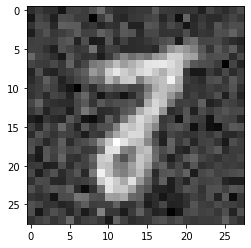

In [85]:
# Lists to keep track of the progresss
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting the training loop!!")
for epoch in range(num_epochs) :
    for i, data in enumerate(dataloader, 0):
         ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        netD.zero_grad()

        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, device=device)
        output = netD(real_cpu).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()
        
        
        
        
        
        
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(fake_label)
        output = netD(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()
        
      
        
        
        
        
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()
        
        
        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
            noise = torch.randn(1, nz, 1, 1, device=device)
            fake = netG(noise)
            fakenp = fake.cpu().detach().numpy()
            fakenp = fakenp.reshape(28,28)
            plt.imshow(fakenp, cmap='gray')

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1
        
        

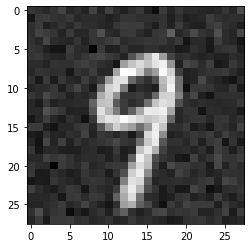

In [128]:
noise = torch.randn(1, nz, 1, 1, device=device)
fake = netG(torch.zeros(1, nz, 1, 1, device=device))
fakenp = fake.cpu().detach().numpy()
fakenp = fakenp.reshape(28,28)
plt.imshow(fakenp, cmap='gray')

### Saving the Models

In [129]:
torch.save(netG.state_dict(), './models/Generator.pth')
torch.save(netD.state_dict(), './models/Discriminator.pth')